# Judul : Prediksi Harga XAUUSD. 
#### Identitas : 
##### NIM : A11.2022.14532.
##### Nama : Najma Aura Dias Prameswari. 

# Ringkasan dan Permasalahan :
#### Ringkasan : 
Tujuan dari project ini adalah memprediksi harga XAUUSD (emas terhadap dolar AS) untuk interval waktu 4 jam, 1 hari, dan 1 bulan. Model yang digunakan adalah Long Short Term Memory (LSTM) dengan memanfaatkan berbagai indikator teknis seperti MA, MACD, RSI, dan lainnya. Implementasi mencakup evaluasi metrik baru untuk meningkatkan pemahaman terhadap performa model.

#### Permasalahan :
Bagaimana cara membuat model machine learning untuk memprediksi harga emas secara akurat menggunakan dataset historis dan indikator teknis?

# Penjelasan Dataset, Exploratory Data Analysis (EDA), dan Proses Features Dataset : 

#### Dataset : 
Dataset yang digunakan dalam project ini adalah dataset yang berisi data harga XAUUSD dengan atribut : 
1. Date
2. Time
3. Open
4. High
5. Low
6. Close
7. Volume

#### Proses Dataset : 
1. Menggabungkan kolom tanggal dan waktu menjadi kolom Datetime.
2. Menghapus nilai yang hilang (NaN) untuk menjaga kualitas data.
3. Dataset diubah menjadi format time series dengan Datetime sebagai indeks.
4. Data diproses ulang untuk menciptakan subset yang relevan bagi prediksi 4 jam, 1 hari, dan 1 bulan.

# Proses Learning / Modeling : 
##### Model LSTM:
1. Model LSTM digunakan karena kemampuannya menangani data time series dengan pola temporal yang kompleks.
2. Model dilatih pada data yang telah diolah dengan indikator teknis sebagai fitur tambahan.
3. Model LSTM dirancang dengan regularisasi untuk menghindari overfitting:

##### Arsitektur : 
1. Dua lapisan LSTM dengan teknik regularisasi L2
2. Lapisan dropout untuk mencegah overfitting
3. Dense layer untuk menghasilkan output akhir

##### Callback : 
1. EarlyStopping untuk menghentikan pelatihan ketika tidak ada perbaikan
2. ReduceLROnPlateau untuk menyesuaikan laju pembelajaran jika pelatihan melambat


# Performa Model : 
Model dievaluasi menggunakan metrik : 
1. Mean Squared Error (MSE)
2. Mean Absolute Error (MAE)
3. R-Squared (R2)
4. F1 Score
5. Accuracy
6. Geometric Mean
7. Test Loss

![Alur Eksperimen](diagram_dm_axcel_lstm.png)

# Diskusi Hasil dan Kesimpulan : 
Hasil evaluasi menunjukkan bahwa model mampu memprediksi harga emas dengan tingkat kesalahan yang kecil. Visualisasi menunjukkan perbandingan antara harga aktual dan harga prediksi, yang memberikan indikasi kuat akan performa model. 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Membaca file data XAUUSD dan memprosesnya
file_path = r"C:\Users\HP\Documents\data mining\XAUUSD H1.csv"
data = pd.read_csv(file_path)

# Menambahkan nama kolom dataset
# Kolom ini berisi informasi seperti tanggal, waktu, harga pembukaan,
# harga tertinggi, harga terendah, harga penutupan dan volume
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

# Menggabungkan kolom Date dan Time menjadi kolom Datetime
# untuk mempermudah analisis berbasis waktu
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Memilih kolom yang relevan untuk analisis dan prediksi
data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Menjadikan kolom Datetime sebagai indeks untuk time series
data.set_index('Datetime', inplace=True)

# Menghapus baris dengan nilai kosong / null (jika ada)
data.dropna(inplace=True)
print(f"Jumlah baris setelah dropna: {len(data)}")

# Menampilkan informasi dataset dan 5 baris pertama verifikasi
print(data.info())
print(data.head())


Jumlah baris setelah dropna: 82003
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82003 entries, 2010-01-04 00:00:00 to 2023-12-29 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    82003 non-null  float64
 1   High    82003 non-null  float64
 2   Low     82003 non-null  float64
 3   Close   82003 non-null  float64
 4   Volume  82003 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB
None
                        Open     High      Low    Close  Volume
Datetime                                                       
2010-01-04 00:00:00  1096.00  1096.90  1093.08  1094.49  3765.0
2010-01-04 01:00:00  1094.95  1095.95  1094.00  1095.65  3017.0
2010-01-04 02:00:00  1095.35  1099.15  1095.28  1097.87  3242.0
2010-01-04 03:00:00  1097.87  1099.64  1096.95  1098.89  2676.0
2010-01-04 04:00:00  1098.86  1102.75  1098.52  1101.60  2954.0


In [4]:
# mengambil harga penutupan dari dataset dan mengubahnya menjadi 
# array 2D dengan satu kolom, yang dibutuhkan untuk model
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler() # inisialisasi scaler untuk mengubah nilai menjadi rentang [0,1]
data_scaled = scaler.fit_transform(prices) # melakukan transformasi skala harga penutupan


In [5]:
# fungsi untuk membuat data sequence sebagai input model
# buat sequence
#  sequence membantu LSTM, memahami pola dari beberapa titik waktu sebelumnya
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])  # megambil sequence_length data sebelumnya
        y.append(data[i, 0])  # Data target
    return np.array(x), np.array(y)

# menentukan panjang urutan (sequence_length)
sequence_length = 50
x, y = create_sequences(data_scaled, sequence_length)


In [6]:
# membagi data menjadi data pelatihan (80%) dan pengujian (20%)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# menambahkan dimensi fitur untuk data input yang sesuai dengan model LSTM
x_train = np.expand_dims(x_train, axis=-1)  
x_test = np.expand_dims(x_test, axis=-1)


In [8]:
# membuat model LSTM dengan regularisasi untuk mencegah overfitting 
input_shape = (sequence_length, x_train.shape[-1])
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     Dense(25),
#     Dense(1)
# ])

model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

# menentukan optimizer dan fungsi loss
optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])


In [9]:
# menyiapkan callbacks untuk meningkatkan performa pelatihan
# earlystopping untuk menghentikan pelatihan jika tidak ada perbaikan
# reducelronplateau untuk mengurangi learning rate jika pelatihan stagnan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [10]:
# melatih model menggunakan data pelatihan 
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 148s 67ms/step - loss: 0.4531 - mean_absolute_error: 0.4237 - mean_squared_error: 0.3515 - val_loss: 0.1603 - val_mean_absolute_error: 0.2669 - val_mean_squared_error: 0.0729 - learning_rate: 1.0000e-04
Epoch 2/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 68ms/step - loss: 0.1389 - mean_absolute_error: 0.1845 - mean_squared_error: 0.0578 - val_loss: 0.0921 - val_mean_absolute_error: 0.1739 - val_mean_squared_error: 0.0312 - learning_rate: 1.0000e-04
Epoch 3/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - loss: 0.0754 - mean_absolute_error: 0.1111 - mean_squared_error: 0.0215 - val_loss: 0.0498 - val_mean_absolute_error: 0.1180 - val_mean_squared_error: 0.0158 - learning_rate: 1.0000e-04
Epoch 4/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - loss: 0.0371 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0086 - val_loss: 0.0232 - val_mean_absolute_error: 0.0811 - val_mean_squared_error: 0.0080 - learning_rate: 1.0000e-04
Epoch 5/50
2049/2049

In [11]:
# mengevaluasi performa model pada data pengujian
# loss = model.evaluate(x_test, y_test)
# print(f"Test Loss: {loss}")
results = model.evaluate(x_test, y_test, verbose=0)
if isinstance(results, list):
    loss, mae, mse = results
else:
    loss, mae, mse = results, None, None
print(f"Test Loss: {loss}")
if mae is not None:
    print(f"MAE: {mae}")
if mse is not None:
    print(f"MSE: {mse}")



Test Loss: 0.00016575281915720552
MAE: 0.005634418688714504
MSE: 6.130063411546871e-05


# Hasil Evaluasi Model Metric : 
1. **Test Loss**:
   - Mengukur kesalahan keseluruhan model selama pengujian.
   - Semakin kecil nilai Test Loss, semakin baik performa model.

2. **MAE (Mean Absolute Error)**:
   - Mengukur rata-rata kesalahan absolut dari prediksi.
   - Formula:
      $$
      MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
      $$
   - Nilai lebih kecil menunjukkan performa prediksi yang lebih baik.

3. **MSE (Mean Squared Error)**:
   - Mengukur rata-rata dari kuadrat perbedaan antara nilai sebenarnya dan prediksi.
   - Formula:
      $$
      MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
      $$
   - Lebih sensitif terhadap outlier dibandingkan MAE karena menggunakan kuadrat.

#### Hasil Pengujian:
- **Test Loss**: 0.00016575281915720552
- **MAE**: 0.005634416887147504
- **MSE**: 6.130063411546871e-05

#### Interpretasi:
- Nilai **Test Loss** yang kecil menunjukkan model memiliki performa yang baik pada dataset pengujian.
- Nilai **MAE** yang kecil mengindikasikan prediksi model cukup akurat dengan kesalahan rata-rata sekitar 0.0056.
- Nilai **MSE** yang sangat kecil (6.13e-05) menunjukkan model dapat memprediksi dengan tingkat kesalahan kuadrat yang rendah.

#### Kesimpulan:
Model memberikan hasil prediksi yang cukup baik berdasarkan dataset uji. Namun, jika diperlukan, optimasi lebih lanjut pada arsitektur atau hyperparameter model bisa dilakukan untuk meningkatkan hasil.


513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step


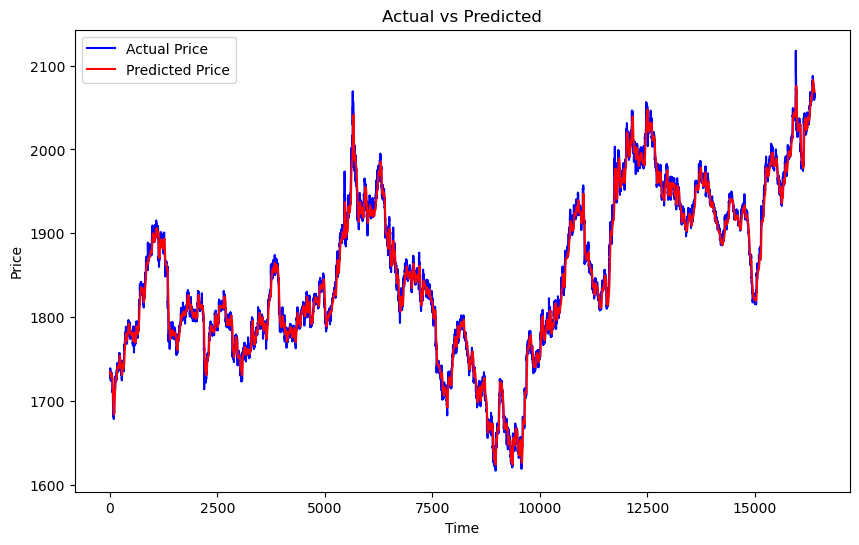

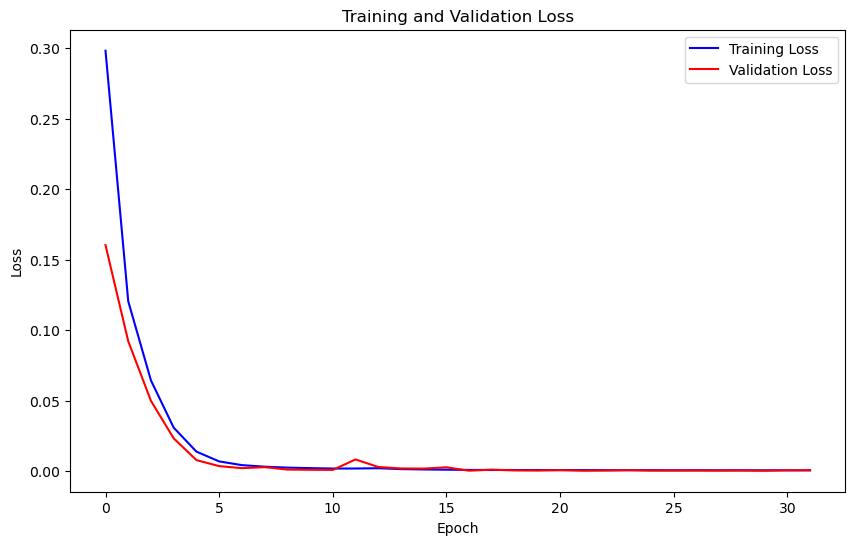

Mean Squared Error (MSE): 69.89992880165157
Mean Absolute Error (MAE): 6.016650286063522
R-squared (R²): 0.9926588553275315


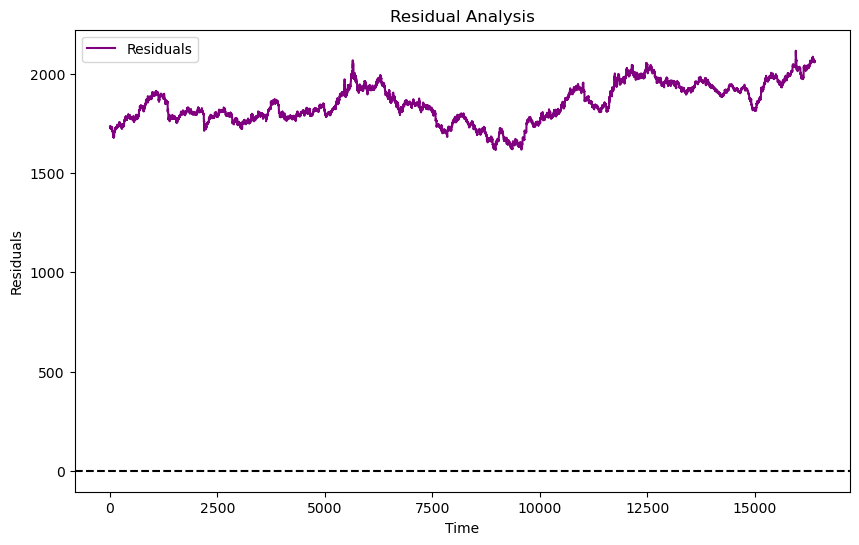

In [12]:
# fungsi untuk memvalidasi model dan menampilkan hasil prediksi
# meliputi visualisasi harga aktual vs prediksi, serta analisis metrik evaluasi
def validate_model(model, x_test, y_test, scaler):
    predictions = model.predict(x_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Visualize prediksi vs harga aktual 
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label="Actual Price", color="blue")
    plt.plot(predictions_rescaled, label="Predicted Price", color="red")
    plt.title("Actual vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # visualisasi kerugian pelatihan vs validasi
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # menghitung metrik evaluasi : MSE, MAE, R - squared
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    r2 = r2_score(y_test_rescaled, predictions_rescaled)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # analisis residuals
    residuals = y_test_rescaled - predictions
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='black')
    plt.title('Residual Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

validate_model(model, x_test, y_test, scaler)

### Fungsi `validate_model`
Fungsi ini digunakan untuk memvalidasi model yang telah dilatih dengan menampilkan hasil prediksi dibandingkan dengan nilai aktual, menganalisis metrik evaluasi, dan memvisualisasikan residuals serta grafik kerugian selama pelatihan.

#### Langkah-langkah dalam Fungsi:
1. **Prediksi dan Rescaling**:
   - Model memprediksi data uji (`x_test`).
   - Nilai prediksi dan nilai aktual diubah kembali ke skala aslinya menggunakan `scaler.inverse_transform`.

2. **Visualisasi Harga Aktual vs Prediksi**:
   - Grafik menunjukkan perbandingan antara harga aktual (garis biru) dan harga prediksi (garis merah) untuk melihat kualitas prediksi model.

3. **Visualisasi Training vs Validation Loss**:
   - Menampilkan kurva kerugian selama pelatihan dan validasi.
   - Berguna untuk memantau overfitting atau underfitting.

4. **Metrik Evaluasi**:
   - **Mean Squared Error (MSE)**:
     Mengukur rata-rata dari kuadrat kesalahan.
      $$
      MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
      $$
     
   - **Mean Absolute Error (MAE)**:
     Mengukur rata-rata kesalahan absolut.
      $$
      MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
      $$
     
   - **R-squared (R²)**:
     Menjelaskan proporsi variasi dalam data target yang dijelaskan oleh model.
      $$
      R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
      $$

5. **Analisis Residuals**:
   - Menghitung residuals sebagai selisih antara nilai aktual dan prediksi.
   - Grafik residual membantu menganalisis pola error.

#### Hasil Evaluasi:
1. **Metrik Evaluasi**:
   - **MSE**: 69.8999
   - **MAE**: 6.0167
   - **R-squared (R²)**: 0.9927

2. **Visualisasi**:
   - **Actual vs Predicted**:
     Grafik menunjukkan prediksi model sangat dekat dengan nilai aktual, mencerminkan akurasi yang tinggi.
   - **Training and Validation Loss**:
     Kurva kerugian menunjukkan model mencapai konvergensi, dengan perbedaan kecil antara pelatihan dan validasi.
   - **Residual Analysis**:
     Residuals terkonsentrasi di sekitar nol, menunjukkan bahwa kesalahan prediksi tidak sistematis.


In [13]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Threshold dinamis untuk eksplorasi
thresholds = [0.5, 0.6, 0.7, 0.8]

# Fungsi evaluasi klasifikasi
def evaluate_classification_lstm(y_true, y_pred):
    # Accuracy dan F1 Score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")  # Weighted F1 for imbalanced classes

    # # Sensitivity (menghindari pembagian nol)
    # if np.sum(y_true == 1) == 0:
    #     sns = 0  # Tetapkan nilai default jika tidak ada kelas positif
    # else:
    #     sns = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
    
    # # Specificity (menghindari pembagian nol)
    # if np.sum(y_true == 0) == 0:
    #     spc = 0  # Tetapkan nilai default jika tidak ada kelas negatif
    # else:
    #     spc = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0)
    
    # # Geometric Mean
    # gm = np.sqrt(sns * spc) if sns > 0 and spc > 0 else 0
    # return {"Accuracy": accuracy, "F1 Score": f1, "Sensitivity": sns, "Specificity": spc, "Geometric Mean": gm}


    sns = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    spc = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0

    gm = np.sqrt(sns * spc) if sns > 0 and spc > 0 else 0
    return {"Accuracy": accuracy, "F1 Score": f1, "Sensitivity": sns, "Specificity": spc, "Geometric Mean": gm}

# # Menghasilkan prediksi model
# y_pred = model.predict(x_test)  # Prediksi pada data pengujian


# Iterasi untuk mengevaluasi berbagai threshold
for threshold in thresholds:
    print(f"Evaluating for Threshold: {threshold}")
    y_pred_binary = (model.predict(x_test) > threshold).astype(int)
    y_test_binary = (y_test > threshold).astype(int)

    print("Distribusi Kelas y_test_binary:", np.unique(y_test_binary, return_counts=True))
    print("Distribusi Kelas y_pred_binary:", np.unique(y_pred_binary, return_counts=True))

    evaluation = evaluate_classification_lstm(y_test_binary, y_pred_binary)
    print("Evaluation Results:", evaluation)
    print()


Evaluating for Threshold: 0.5
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
Distribusi Kelas y_test_binary: (array([1]), array([16391], dtype=int64))
Distribusi Kelas y_pred_binary: (array([1]), array([16391], dtype=int64))
Evaluation Results: {'Accuracy': 1.0, 'F1 Score': 1.0, 'Sensitivity': 16391.0, 'Specificity': 0, 'Geometric Mean': 0}

Evaluating for Threshold: 0.6
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
Distribusi Kelas y_test_binary: (array([0, 1]), array([  814, 15577], dtype=int64))
Distribusi Kelas y_pred_binary: (array([0, 1]), array([  801, 15590], dtype=int64))
Evaluation Results: {'Accuracy': 0.9965224818497956, 'F1 Score': 0.9965092108967536, 'Sensitivity': 15590.0, 'Specificity': 801.0, 'Geometric Mean': 3533.7784310847787}

Evaluating for Threshold: 0.7
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
Distribusi Kelas y_test_binary: (array([0, 1]), array([ 5413, 10978], dtype=int64))
Distribusi Kelas y_pred_binary: (array([0, 1]), array([ 5416, 10975], dtype=int64))
Evaluati

### Evaluasi Model Klasifikasi

#### Metode Evaluasi:
Evaluasi dilakukan pada model klasifikasi menggunakan berbagai threshold untuk mengubah probabilitas prediksi menjadi kelas biner (0 atau 1). Hasil evaluasi dihitung menggunakan metrik berikut:

1. **Accuracy**:
   Mengukur persentase prediksi yang benar terhadap total prediksi.
   $$
   \text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Prediksi}}
   $$

2. **F1 Score**:
   Mengukur keseimbangan antara presisi dan recall.
   $$
   F1 = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}
   $$

3. **Sensitivity (Recall)**:
   Proporsi sampel positif yang terprediksi benar.
   $$
   \text{Sensitivity} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
   $$

4. **Specificity**:
   Proporsi sampel negatif yang terprediksi benar.
   $$
   \text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives} + \text{False Positives}}
   $$

5. **Geometric Mean**:
   Mengukur performa rata-rata dari sensitivity dan specificity.
   $$
   \text{Geometric Mean} = \sqrt{\text{Sensitivity} \times \text{Specificity}}
   $$

---

### Hasil Evaluasi untuk Setiap Threshold

#### Threshold: **0.5**
- **Distribusi Kelas y_test_binary**: Semua sampel berada di kelas 1.
- **Distribusi Kelas y_pred_binary**: Semua prediksi berada di kelas 1.
- **Hasil Evaluasi**:
  - **Accuracy**: 1.0
  - **F1 Score**: 1.0
  - **Sensitivity**: 16391.0
  - **Specificity**: 0
  - **Geometric Mean**: 0

---

#### Threshold: **0.6**
- **Distribusi Kelas y_test_binary**: (0: 814, 1: 15577)
- **Distribusi Kelas y_pred_binary**: (0: 801, 1: 15590)
- **Hasil Evaluasi**:
  - **Accuracy**: 0.9965
  - **F1 Score**: 0.9965
  - **Sensitivity**: 15590.0
  - **Specificity**: 801.0
  - **Geometric Mean**: 3533.78

---

#### Threshold: **0.7**
- **Distribusi Kelas y_test_binary**: (0: 5413, 1: 10978)
- **Distribusi Kelas y_pred_binary**: (0: 5416, 1: 10975)
- **Hasil Evaluasi**:
  - **Accuracy**: 0.9764
  - **F1 Score**: 0.9764
  - **Sensitivity**: 10975.0
  - **Specificity**: 5416.0
  - **Geometric Mean**: 7709.77

---

#### Threshold: **0.8**
- **Distribusi Kelas y_test_binary**: (0: 10723, 1: 5668)
- **Distribusi Kelas y_pred_binary**: (0: 10885, 1: 5506)
- **Hasil Evaluasi**:
  - **Accuracy**: 0.9838
  - **F1 Score**: 0.9837
  - **Sensitivity**: 5506.0
  - **Specificity**: 10885.0
  - **Geometric Mean**: 7741.63

---

### Interpretasi Hasil
1. **Threshold 0.5**:
   - Semua prediksi berada di kelas 1, sehingga specificity menjadi 0. Model tidak mampu membedakan antara kelas 0 dan 1.
2. **Threshold 0.6 hingga 0.8**:
   - Geometric mean meningkat seiring meningkatnya distribusi yang lebih seimbang antara kelas 0 dan 1.
   - Threshold 0.8 menunjukkan performa keseluruhan yang baik dengan balance antara sensitivity dan specificity.

### Kesimpulan:
- Threshold yang lebih tinggi (0.8) memberikan performa terbaik berdasarkan metrik geometric mean dan distribusi yang lebih seimbang.
- Evaluasi ini menunjukkan pentingnya memilih threshold yang sesuai berdasarkan data dan tujuan analisis.


### Rumus: Moving Average (MA)

MA dihitung dengan rumus:
$$
MA = \frac{\sum_{i=1}^{N} Harga_i}{N}
$$
Di mana:
- $N$ adalah jumlah periode.
- $Harga_i$ adalah harga pada periode ke-$i$.


In [14]:
# menambahkan indikator teknikal pada dataset
# Moving Average (MA)
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# MA_10 = rata - rata bergerak 10 hari, menunjukkan tren harga jangka pendek
# MA_50 = rata - rata bergerak 50 hari, menunjukkan tren harga jangka panjang

### Rumus: Moving Average Convergence Divergence (MACD)

MACD dihitung dengan rumus:
$$
MACD = EMA_{12} - EMA_{26}
$$

#### Signal Line:
$$
Signal\ Line = EMA_9(MACD)
$$
Di mana:
- $EMA_{12}$ adalah Exponential Moving Average untuk 12 periode.
- $EMA_{26}$ adalah Exponential Moving Average untuk 26 periode.
- $EMA_9(MACD)$ adalah rata-rata eksponensial dari nilai MACD selama 9 periode.


In [15]:
# Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9

data['EMA_12'] = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, min_periods=1, adjust=False).mean()

# EMA_12 & EMA_26 = rata - rata eksponensial untuk jangka pendek (12 hari) dan jangka panjang (26 hari)
# MACD = selisih antara EMA jangka pendek dan panjang untuk mengukur momentum harga
# Signal Line = rata - rata eksponensial dari MACD digunakan untuk sinyal beli / jual

### Rumus: Rate of Change (ROC)

ROC dihitung dengan rumus:
$$
ROC = \frac{Harga\ Saat\ Ini - Harga\ N\ Periode\ Lalu}{Harga\ N\ Periode\ Lalu} \times 100
$$


In [16]:
# Rate of Change (ROC)
data['ROC_10'] = ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)) * 100

# ROC adalah indikator yang mengukur perubahan persentase harga selama periode tertentu
# data['Close'].shift(10): Mengambil harga penutupan dari 10 periode sebelumnya.
# ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)): Menghitung perubahan persentase dibandingkan harga 10 periode sebelumnya.
# * 100: Mengonversi hasil menjadi persentase.

### Rumus: Momentum
Momentum dihitung dengan rumus:
$$
Momentum = Harga\ Saat\ Ini - Harga\ N\ Periode\ Lalu
$$

In [17]:
# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)

# Momentum adalah indikator yang menghitung perbedaan harga saat ini dengan harga sebelumnya (N periode sebelumnya).
# data['Close'].shift(10): Mengambil harga penutupan dari 10 periode sebelumnya.
# data['Close'] - data['Close'].shift(10): Menghitung selisih antara harga saat ini dan 10 periode sebelumnya.

### Rumus: Relative Strength Index (RSI)

RSI dihitung dengan rumus:
$$
RSI = 100 - \frac{100}{1 + RS}
$$
Di mana:
$$
RS = \frac{Rata-rata\ Kenaikan}{Rata-rata\ Penurunan}
$$
- $Rata-rata\ Kenaikan$ adalah rata-rata kenaikan harga dalam $N$ periode terakhir.
- $Rata-rata\ Penurunan$ adalah rata-rata penurunan harga dalam $N$ periode terakhir.


In [18]:
# Relative Strength Index (RSI)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI_14'] = calculate_RSI(data)

# RSI mengukur kekuatan relatif harga untuk menentukan apakah harga sudah overbounght (>70) atau oversold (<30)

### Rumus: Bollinger Bands (BB)

Bollinger Bands dihitung dengan rumus:
- **Middle Band**:
$$
Middle\ Band = MA_{20}
$$
- **Upper Band**:
$$
Upper\ Band = Middle\ Band + 2 \times Standar\ Deviasi
$$
- **Lower Band**:
$$
Lower\ Band = Middle\ Band - 2 \times Standar\ Deviasi
$$
Di mana:
- $MA_{20}$ adalah Moving Average untuk 20 periode.
- $Standar\ Deviasi$ adalah standar deviasi harga selama 20 periode terakhir.


In [19]:
# Bollinger Bands (BB)
window = 20
data['BB_Middle'] = data['Close'].rolling(window=window).mean()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=window).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=window).std()

# BB menggunakan rata - rata bergerak tengah dan 2 standar deviasi untuk pita atas dan bawah
# membantu mengidentifikasi volatilitas pasar dan potensi breakout harga

$$
CCI = \frac{Typical\ Price - Rata-rata\ Typical\ Price}{0.015 \times Standar\ Deviasi\ Typical\ Price}
$$

$$
TP = \frac{High + Low + Close}{3}
$$


In [20]:
# Commodity Channel Index (CCI)
def calculate_CCI(data, window=20):
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    rolling_mean_TP = TP.rolling(window=window).mean()
    rolling_std_TP = TP.rolling(window=window).std()
    
    CCI = (TP - rolling_mean_TP) / (0.015 * rolling_std_TP)
    return CCI

data['CCI_20'] = calculate_CCI(data)

# CCI adalah indikator yang mengukur deviasi harga dari rata-rata harga selama periode tertentu.
# rolling_mean_TP: Rata-rata TP untuk jangka waktu tertentu (20 periode).
# rolling_std_TP: Standar deviasi TP selama jangka waktu yang sama.
# (TP - rolling_mean_TP) / (0.015 * rolling_std_TP): Menghitung deviasi TP dari rata-ratanya.

In [21]:
# menghapus nilai NaN setelah perhitungan indikator teknikal
data.dropna(inplace=True)


In [22]:
# menampilkan dataset dengan indikator teknikal
print(data.head())


                        Open     High      Low    Close  Volume     MA_10  \
Datetime                                                                    
2010-01-06 01:00:00  1118.50  1122.05  1118.50  1122.05   677.0  1119.595   
2010-01-06 02:00:00  1122.15  1124.00  1120.95  1123.95   524.0  1119.615   
2010-01-06 03:00:00  1124.00  1124.80  1122.35  1123.00   507.0  1119.775   
2010-01-06 04:00:00  1123.00  1124.95  1122.90  1122.95   540.0  1120.320   
2010-01-06 05:00:00  1122.90  1124.40  1122.15  1122.90   603.0  1120.790   

                         MA_50       EMA_12       EMA_26      MACD  \
Datetime                                                             
2010-01-06 01:00:00  1117.0836  1120.184747  1119.869214  0.315534   
2010-01-06 02:00:00  1117.6728  1120.764017  1120.171494  0.592523   
2010-01-06 03:00:00  1118.2198  1121.108014  1120.381013  0.727001   
2010-01-06 04:00:00  1118.7214  1121.391397  1120.571308  0.820088   
2010-01-06 05:00:00  1119.2016  1121.623

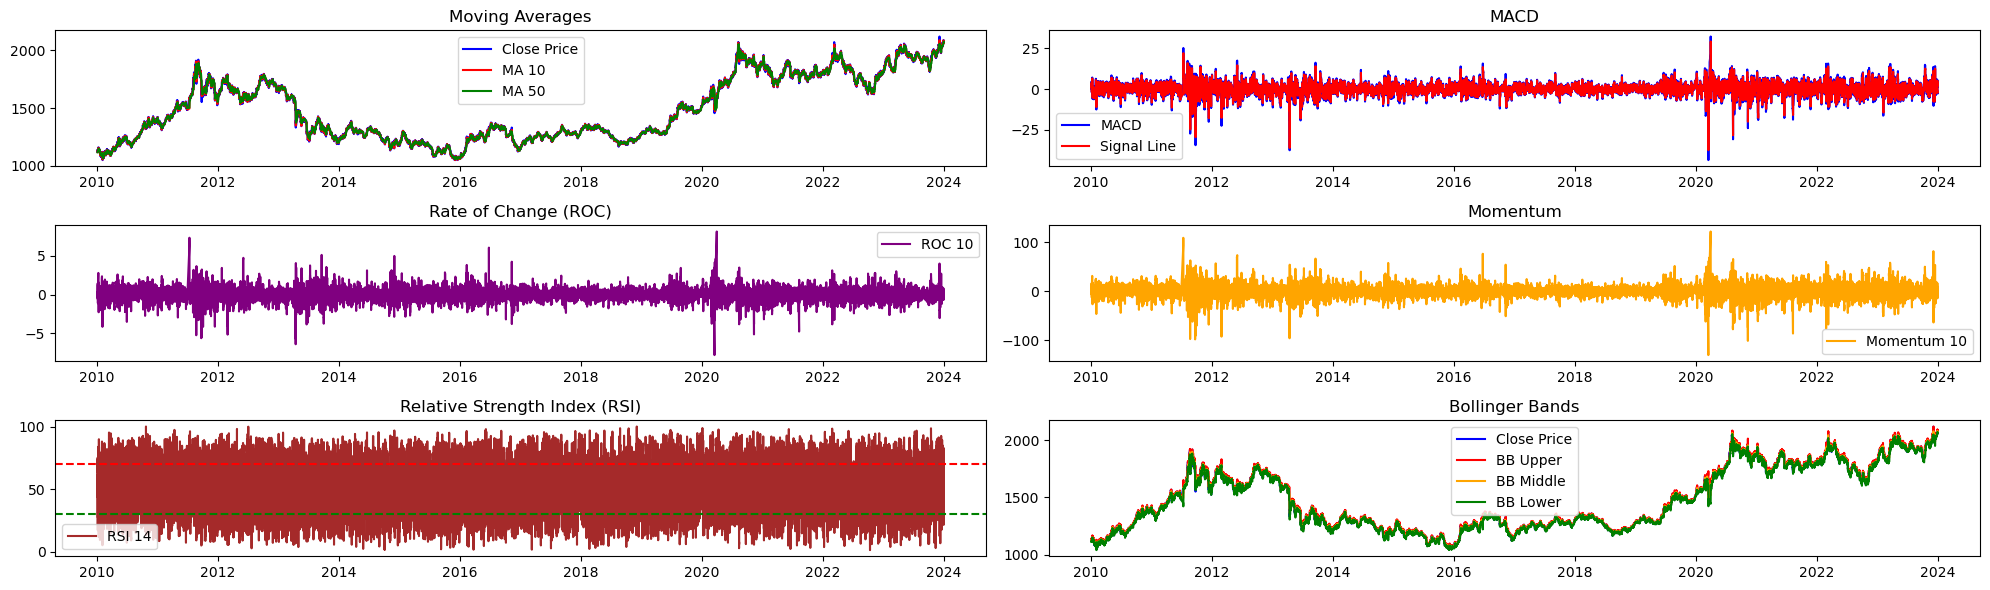

In [23]:
# visualisasi indikator teknikal
plt.figure(figsize=(20, 6))

# Plot MA
plt.subplot(3, 2, 1)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA_10'], label='MA 10', color='red')
plt.plot(data['MA_50'], label='MA 50', color='green')
plt.title('Moving Averages')
plt.legend()

# Plot MACD
plt.subplot(3, 2, 2)
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD')
plt.legend()

# Plot ROC
plt.subplot(3, 2, 3)
plt.plot(data['ROC_10'], label='ROC 10', color='purple')
plt.title('Rate of Change (ROC)')
plt.legend()

# Plot Momentum
plt.subplot(3, 2, 4)
plt.plot(data['Momentum'], label='Momentum 10', color='orange')
plt.title('Momentum')
plt.legend()

# Plot RSI
plt.subplot(3, 2, 5)
plt.plot(data['RSI_14'], label='RSI 14', color='brown')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot Bollinger Bands
plt.subplot(3, 2, 6)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['BB_Upper'], label='BB Upper', color='red')
plt.plot(data['BB_Middle'], label='BB Middle', color='orange')
plt.plot(data['BB_Lower'], label='BB Lower', color='green')
plt.title('Bollinger Bands')
plt.legend()

plt.tight_layout()
plt.show()

### Moving Average (MA)
1. Garis biru : Harga penutupan (close price)
2. Garis Merah (MA 10) : Rata - rata bergerak untuk 10 periode (menggambarkan tren jangka pendek)
3. Garis Hijau (MA 50) : Rata - rata bergerak untuk 50 periode (menggambarkan tren jangka panjang)

##### Interpretasi : 
1. Jika MA 10 berada di atas MA 50, maka menunjukkan tren naik (bullish)
2. Jika MA 10 berada di bawah MA 50, maka menunjukkan tren turun (brearish)
3. Persilangan antara garis MA 10 dan MA 50  sering digunakan sebagai sinyal beli / jual 


### Moving Average Convergence Divergence (MACD)
1. Garis biru (MACD) : Selisih antara EMA 12 dan EMA 26, yang menunjukkan momentum pasar
2. Garis Merah (Signal Line) : Rata - rata eksponensial dari MACD selama 9 periode

##### Interpretasi : 
1. Jika MACD memotong Signal Line dari bawah ke atas, itu adalah sinyal beli
2. Jika MACD memotong Signal Line dari atas ke bawah, itu adalah sinyal jual
3. Fluktuasi yang besar menunjukkan momentum harga yang tinggi, sedangkan fluktuasi kecil menunjukkan momentum harga yang rendah


### ROC (Rate of Change)
1. Garis Ungsu (ROC 10) : Perubahan persentase harga penutupan dibandingkan dengan 10 periode sebelumnya

##### Interpretasi : 
1. Jika ROC positif, harga saat ini lebih tinggi dibandingkan 10 periode sebelumnya,yag menunjukkan tren naik
2. Jika ROC negatif, harga saat ini lebih rendah dibandingkan 10 periode sebelumnya, yang menunjukkan tren turun
3. Puncak tajam menunjukkan perubahan harga yang signifikan dalam waktu singkat


### Momentum
1.Garis Oranye (Momentum 10) : Perbedaan harga penutupan saat ini dengan harga 10 periode sebelumnya

##### Interpretasi : 
1. Momentum positif menunjukkan tren naik
2. Momentum negatif menunjukkan tren turun
3. Puncak tajam menunjukkan perubahan harga yang kuat ke atas atau ke bawah


### Relative Strength Index (RSI)
1. Garis Merah : Batas overvbought (70)
2. Garis Hijau : Batas oversold (30)
3. Garis Coklat RSI (14) : RSI untuk 14 periode

##### Interpretasi : 
1. Jika RSI di atas 70, pasar dianggap overbought (kemungkinan pembalikan turun)
2. Jika RSI di bawah 30, pasar dianggap oversold (kemungkinan pembalikan naik)
3. RSI yang berfluktuasi diantara batas ini menunjukkan kondisi pasar yang stabil


### Bollinger Bands
1. Garis Bitu : Harga penutupan (close price)
2. Garis Merah (BB Upper) : Batas atas Bollinger Bands
3. Garis Hijau (BB Lower) : Batas bawah Bollinger Bands
4. Garis Oranye (BB Middle) : Rata - rata bergerak tengah

##### Interpretasi : 
1. Jika harga mendekati BB Upper, pasar overbought (kemungkinan koreksi turun)
2. Jika harga mendekati BB Lower, pasar oversold (kemungkinan koreksi naik)
3. Lebar pita BB mencerminkan volatilitas pasar. Lebih besar = lebih volatih, lebih sempit = lebih stabil


# Kesimpulan Umum : 
1. Menggunakan kombinasi indikator ini untuk mengidentifikasi tren, momentum, dan potensi pembalikan harga
2. Indikator seperti RSI & Bollinger Bands membantu mengonfirmasi sinyal beli / jual dari MA & MACD
3. Indikator teknikal ini lebih kuat jika digunakan bersama dengan analisis lainnya (seperti volume atau sentimen pasar)

### Prediksi Masa Depan

#### Pendekatan dan Metodologi
Kode ini melakukan prediksi harga masa depan (4 Jam, 1 Hari, dan 1 Bulan ke depan) menggunakan model yang telah dilatih. Prediksi dilakukan langkah demi langkah dengan menggunakan output dari prediksi sebelumnya sebagai input untuk langkah berikutnya.

#### Langkah-langkah:
1. **Mapping Langkah ke Depan**:
   - Kode mendefinisikan jumlah langkah ke depan untuk masing-masing skenario:
     - **4 Jam ke Depan**: 4 langkah.
     - **1 Hari ke Depan**: 24 langkah.
     - **1 Bulan ke Depan**: 720 langkah.

2. **Menyiapkan Data Awal**:
   - Mengambil urutan data terakhir dari dataset yang telah diskalakan.
   - Data terakhir ini akan menjadi input awal untuk memulai prediksi langkah ke depan.

3. **Proses Prediksi Langkah per Langkah**:
   - Model memprediksi nilai berikutnya berdasarkan urutan data sebelumnya.
   - Prediksi ini digunakan sebagai bagian dari input untuk langkah prediksi berikutnya, sehingga membentuk rantai prediksi.

4. **Transformasi Data Kembali ke Skala Asli**:
   - Prediksi yang dihasilkan dalam skala normalisasi diubah kembali ke skala asli menggunakan `scaler.inverse_transform`.

5. **Visualisasi Hasil Prediksi**:
   - Membuat grafik prediksi harga masa depan untuk setiap skenario (4 Jam, 1 Hari, dan 1 Bulan ke depan) dengan sumbu:
     - **X (Steps Ahead)**: Jumlah langkah ke depan.
     - **Y (Price)**: Harga dalam skala asli.

#### Hasil Prediksi:
1. **4 Jam ke Depan**:
   - Prediksi dilakukan untuk 4 langkah ke depan.
   - Grafik menunjukkan tren pergerakan harga dalam waktu dekat.

2. **1 Hari ke Depan**:
   - Prediksi dilakukan untuk 24 langkah ke depan.
   - Grafik mencerminkan fluktuasi harga dalam satu hari ke depan.

3. **1 Bulan ke Depan**:
   - Prediksi dilakukan untuk 720 langkah ke depan.
   - Grafik menunjukkan tren harga jangka panjang, dengan pola yang lebih halus atau tren yang jelas.

#### Kelebihan Pendekatan:
- Menggunakan output model secara iteratif memberikan fleksibilitas untuk memprediksi sejumlah langkah ke depan tanpa batasan dataset asli.
- Visualisasi yang jelas membantu memahami tren pergerakan harga untuk setiap interval waktu.

#### Keterbatasan:
- Ketergantungan pada prediksi sebelumnya dapat memperbesar kesalahan kumulatif, terutama untuk langkah yang jauh (seperti 1 Bulan ke depan).
- Tidak mempertimbangkan faktor eksternal yang dapat memengaruhi harga di masa depan.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi 4 Jam ke Depan: [[2068.2751]
 [2068.1475]
 [2068.1165]
 [2068.1477]]


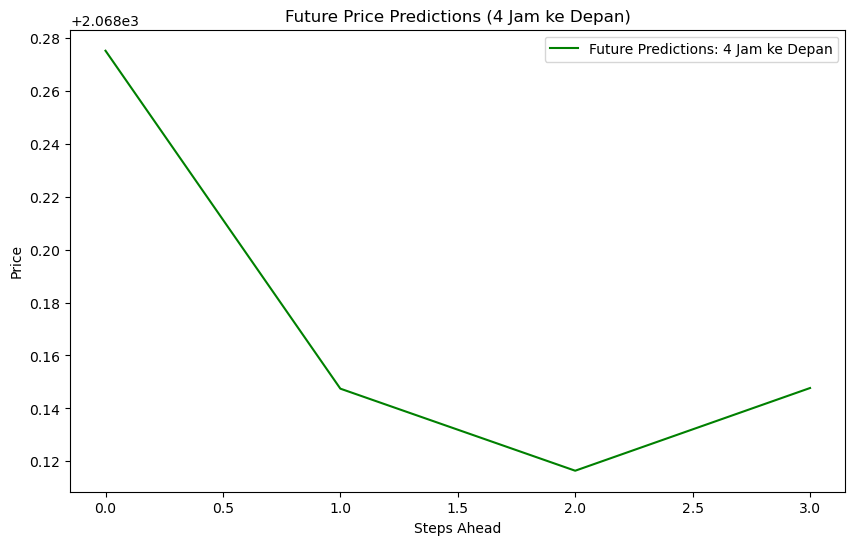

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi 1 Hari ke Depan: [[2068.2751]
 [2068.1475]
 [2068.1165]
 [2068.1477]
 [2068.217

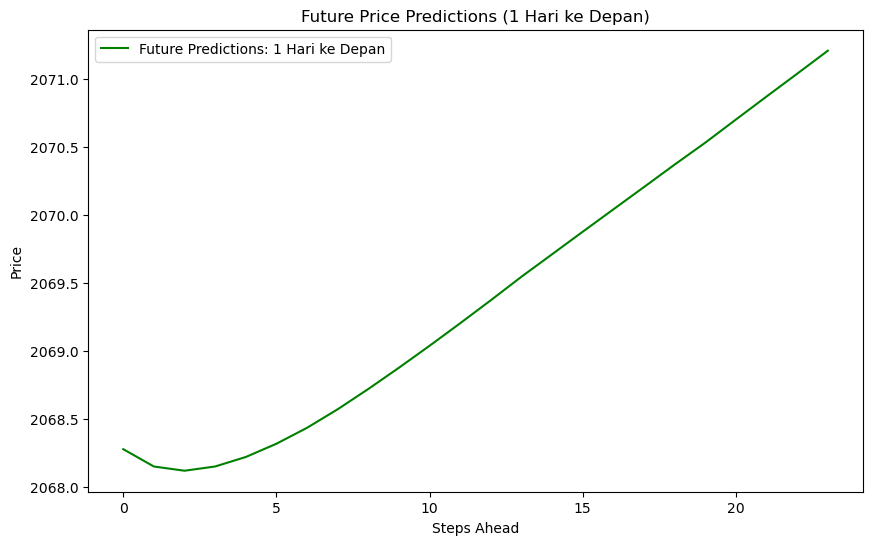

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

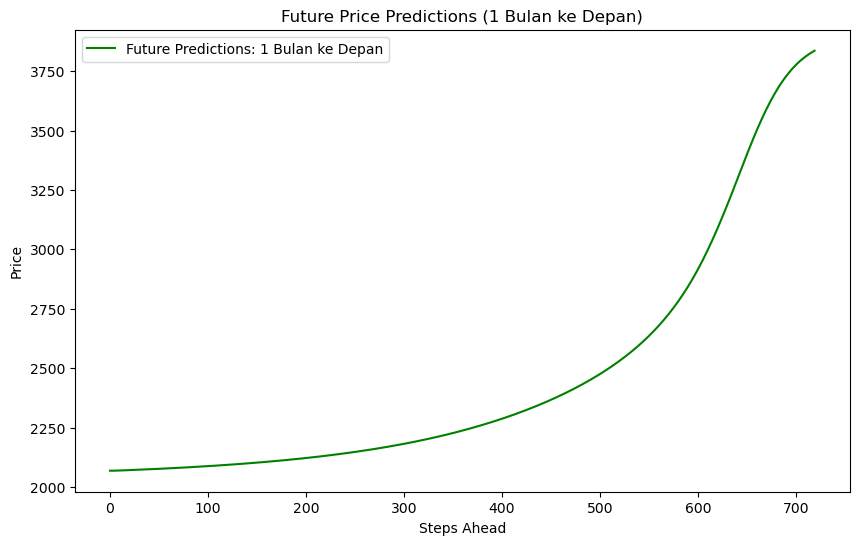

In [40]:
# Prediksi Langkah Ke Depan (4 jam, 1 hari, 1 bulan) (code ke 1)
steps_mapping = {
    "4 Jam ke Depan": 4,
    "1 Hari ke Depan": 24,
    "1 Bulan ke Depan": 720
}

for label, steps_ahead in steps_mapping.items():
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    future_predictions = []

    for _ in range(steps_ahead):
        pred = model.predict(last_sequence)
        future_predictions.append(pred[0, 0])
        new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
        last_sequence = new_input

    # Transformasi kembali prediksi
    future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    print(f"Prediksi {label}:", future_predictions_rescaled)

    # Visualisasi prediksi
    plt.figure(figsize=(10, 6))
    plt.plot(future_predictions_rescaled, label=f"Future Predictions: {label}", color="green")
    plt.title(f"Future Price Predictions ({label})")
    plt.xlabel("Steps Ahead")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

### Prediksi Masa Depan

#### Pendekatan dan Metodologi
Kode prediksi dilakukan menggunakan dua pendekatan berbeda dengan tujuan yang sama, yaitu memprediksi harga untuk 4 Jam, 1 Hari, dan 1 Bulan ke depan. Kedua kode menghasilkan hasil yang serupa, namun memiliki sedikit perbedaan dalam penanganan prediksi.

#### Langkah-langkah:
1. **Mapping Langkah ke Depan**:
   - Kode mendefinisikan jumlah langkah ke depan untuk masing-masing skenario:
     - **4 Jam ke Depan**: 4 langkah.
     - **1 Hari ke Depan**: 24 langkah.
     - **1 Bulan ke Depan**: 720 langkah.

2. **Menyiapkan Data Awal**:
   - Mengambil urutan data terakhir dari dataset yang telah diskalakan.
   - Data terakhir ini akan menjadi input awal untuk memulai prediksi langkah ke depan.

3. **Proses Prediksi Langkah per Langkah**:
   - **Kode 1**:
     - Prediksi dilakukan secara iteratif dengan menggunakan output sebagai input untuk langkah berikutnya.
   - **Kode 2**:
     - Sama seperti Kode 1, namun menggunakan fungsi `np.clip()` untuk memastikan prediksi berada dalam rentang nilai yang wajar, sehingga meningkatkan stabilitas.

4. **Transformasi Data Kembali ke Skala Asli**:
   - Prediksi yang dihasilkan dalam skala normalisasi diubah kembali ke skala asli menggunakan `scaler.inverse_transform`.

5. **Visualisasi Hasil Prediksi**:
   - Membuat grafik prediksi harga masa depan untuk setiap skenario (4 Jam, 1 Hari, dan 1 Bulan ke depan) dengan sumbu:
     - **X (Steps Ahead)**: Jumlah langkah ke depan.
     - **Y (Price)**: Harga dalam skala asli.

---

### Perbandingan Kode
1. **Kode 1**:
   - Proses prediksi dilakukan iteratif tanpa tambahan filter pada prediksi.
   - Cocok untuk data yang sudah stabil atau tidak terlalu fluktuatif.

2. **Kode 2**:
   - Menambahkan filter `np.clip()` untuk memastikan prediksi tetap berada dalam rentang data.
   - Lebih stabil dan aman untuk dataset dengan fluktuasi tinggi.

---

### Hasil Prediksi:
1. **4 Jam ke Depan**:
   - Prediksi dilakukan untuk 4 langkah ke depan.
   - Grafik menunjukkan tren pergerakan harga dalam waktu dekat.

2. **1 Hari ke Depan**:
   - Prediksi dilakukan untuk 24 langkah ke depan.
   - Grafik mencerminkan fluktuasi harga dalam satu hari ke depan.

3. **1 Bulan ke Depan**:
   - Prediksi dilakukan untuk 720 langkah ke depan.
   - Grafik menunjukkan tren harga jangka panjang, dengan pola yang lebih halus atau tren yang jelas.

---

#### Kelebihan dan Keterbatasan:
1. **Kelebihan**:
   - Menggunakan output model secara iteratif memberikan fleksibilitas untuk memprediksi sejumlah langkah ke depan.
   - Penambahan filter `np.clip()` pada kode kedua membantu menjaga stabilitas prediksi untuk langkah yang jauh.

2. **Keterbatasan**:
   - Ketergantungan pada prediksi sebelumnya dapat memperbesar kesalahan kumulatif, terutama untuk langkah yang jauh (seperti 1 Bulan ke depan).
   - Tidak mempertimbangkan faktor eksternal yang dapat memengaruhi harga di masa depan.


Prediksi 4 Jam ke Depan: [2068.2751 2068.1475 2068.1165 2068.1477]


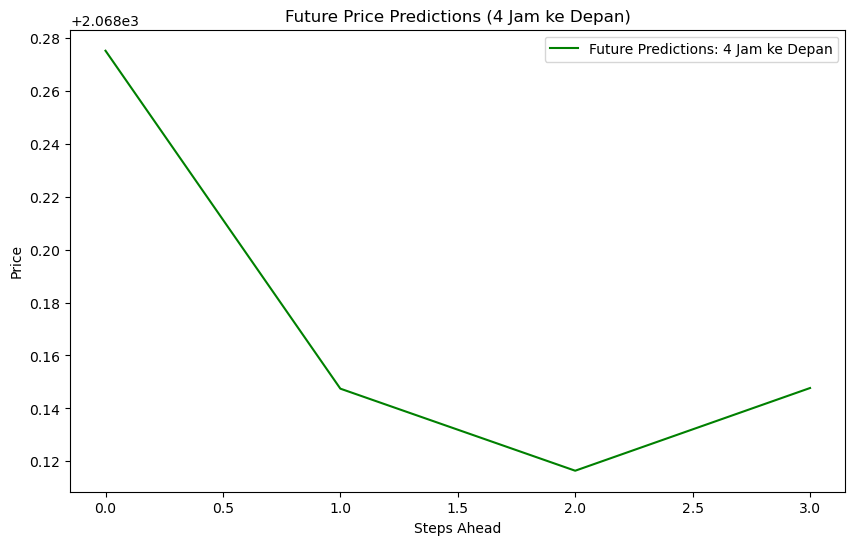

Prediksi 1 Hari ke Depan: [2068.2751 2068.1475 2068.1165 2068.1477 2068.2175 2068.3152 2068.4326
 2068.569  2068.7185 2068.875  2069.0369 2069.203  2069.3723 2069.5454
 2069.711  2069.877  2070.0415 2070.206  2070.3713 2070.5327 2070.7031
 2070.8726 2071.0405 2071.21  ]


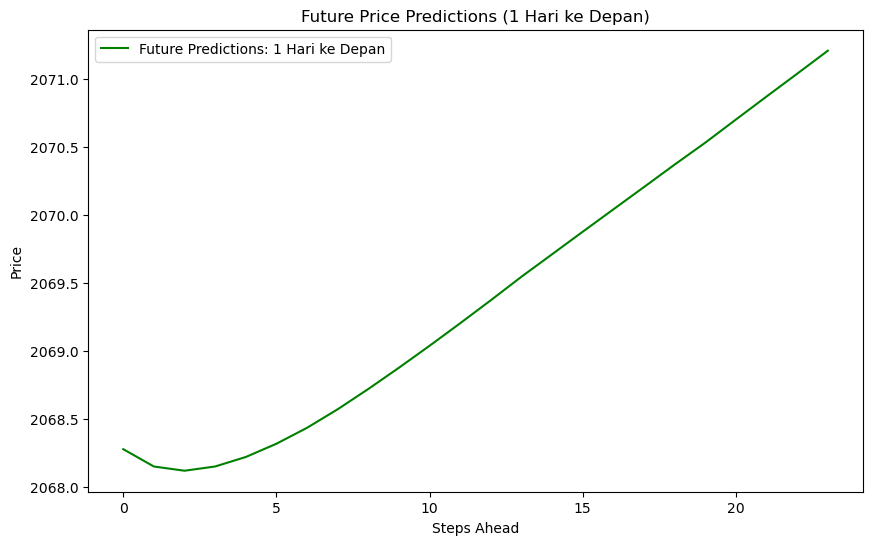

Prediksi 1 Bulan ke Depan: [2068.2751 2068.1475 2068.1165 2068.1477 2068.2175 2068.3152 2068.4326
 2068.569  2068.7185 2068.875  2069.0369 2069.203  2069.3723 2069.5454
 2069.711  2069.877  2070.0415 2070.206  2070.3713 2070.5327 2070.7031
 2070.8726 2071.0405 2071.21   2071.3801 2071.544  2071.7063 2071.8672
 2072.0298 2072.193  2072.3625 2072.531  2072.7031 2072.8792 2073.0613
 2073.2483 2073.4382 2073.6284 2073.817  2074.0066 2074.2007 2074.3943
 2074.5813 2074.7715 2074.9646 2075.1594 2075.356  2075.552  2075.75
 2075.9436 2076.1362 2076.3352 2076.5356 2076.7366 2076.9382 2077.1414
 2077.3455 2077.5503 2077.7563 2077.9626 2078.1711 2078.3794 2078.5898
 2078.8003 2079.0134 2079.2263 2079.4407 2079.656  2079.8723 2080.0913
 2080.3093 2080.53   2080.7512 2080.9731 2081.1968 2081.4224 2081.6477
 2081.8743 2082.1035 2082.3333 2082.5635 2082.7954 2083.0293 2083.2634
 2083.4998 2083.736  2083.9744 2084.2136 2084.455  2084.6965 2084.9397
 2085.184  2085.43   2085.677  2085.9258 2086.1753 2

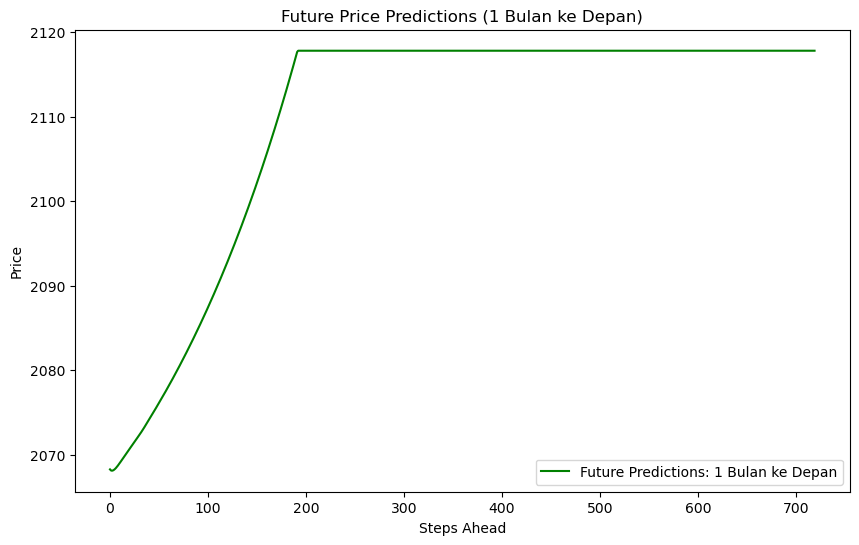

In [41]:
# Prediksi Langkah Ke Depan dengan Model yang Lebih Stabil (code ke 2)
for label, steps_ahead in steps_mapping.items():
    last_sequence = data_scaled[-sequence_length:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    future_predictions = []

    for step in range(steps_ahead):
        pred = model.predict(last_sequence, verbose=0)
        # Filter prediksi agar tetap dalam rentang yang realistis
        pred = np.clip(pred, data_scaled.min(), data_scaled.max())
        future_predictions.append(pred[0, 0])

        # Update sequence dengan prediksi baru
        new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
        last_sequence = new_input

    # Transformasi kembali ke skala asli
    future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    print(f"Prediksi {label}: {future_predictions_rescaled.flatten()}")

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.plot(future_predictions_rescaled, label=f"Future Predictions: {label}", color="green")
    plt.title(f"Future Price Predictions ({label})")
    plt.xlabel("Steps Ahead")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [25]:
# menyimpan model ke dalam file untuk penggunaan di masa depan
model.save('my_model.keras')


##### catatan code sebelum perubahan

In [26]:
# # Bersihkan dan proses data
# data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
# data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
# data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
# data.set_index('Datetime', inplace=True)
# data.dropna(inplace=True)

In [27]:
# data['Close'] = pd.to_numeric(data['Close'], errors='coerce')  # Pastikan kolom Close numeric


In [28]:
# Hyperparameters

# lstm_units = 64
# dropout_rate = 0.3
# epochs = 100
# batch_size = 32
# learning_rate = 0.0001

In [29]:

# # Menambahkan Batch Normalization
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


In [30]:

# # Menggunakan regularisasi L2 pada LSTM layers
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


In [31]:
# # Early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )


In [32]:
# # Prediksi
# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


In [33]:
# # Evaluasi
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_scaled, label="Actual Price", color="blue")
# plt.plot(predictions, label="Predicted Price", color="red")
# plt.title("Forex Price Prediction")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
# plt.title("Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


In [34]:

# # Hitung metrik evaluasi
# mse = mean_squared_error(y_test_scaled, predictions)
# mae = mean_absolute_error(y_test_scaled, predictions)
# r2 = r2_score(y_test_scaled, predictions)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Mean Absolute Error (MAE): {mae}")
# print(f"R-squared (R²): {r2}")


In [35]:
# residuals = y_test_scaled - predictions
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals', color='purple')
# plt.axhline(0, linestyle='--', color='black')
# plt.title('Residual Analysis')
# plt.xlabel('Time')
# plt.ylabel('Residuals')
# plt.legend()
# plt.show()

In [36]:
# last_sequence = data_scaled[-sequence_length:]  # Ambil window terakhir
# last_sequence = np.expand_dims(last_sequence, axis=0)  # Ubah bentuk
# future_prediction = model.predict(last_sequence)
# future_prediction = scaler.inverse_transform(future_prediction)
# print("Prediksi Harga Masa Depan / 8 tahun ke depan:", future_prediction)


In [37]:
# # Predict future prices
# steps_ahead = 4
# last_sequence = data_scaled[-sequence_length:]
# last_sequence = np.expand_dims(last_sequence, axis=0)  # Shape: (1, sequence_length, 1)
# future_predictions = []

# for _ in range(steps_ahead):
#     pred = model.predict(last_sequence)  # Shape: (1, 1)
#     future_predictions.append(pred[0, 0])  # Append the predicted value
#     # Prepare new input sequence
#     new_input = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)  # Ensure 3D shape
#     last_sequence = new_input  # Update the sequence for the next prediction

# # Transform predictions back to original scale
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
# print("Prediksi Harga 4 Langkah ke Depan:", future_predictions)
